<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/Another_object_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read the Data

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive/

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches

In [ ]:
def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

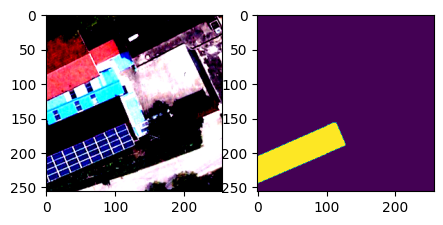

In [ ]:
img =TF.to_tensor(Image.open("processed_data/1.bmp"))
msk = TF.to_tensor(TF.to_grayscale(Image.open("processed_data/1_mask.bmp")))
plot(img,msk)

## Bounding Box
For the task of object detection, we need to convert the segmentation masks into bounding boxes, so we try the function from `torchvision`. The shortcoming of this method is that the bounding box will cover all panels at once, not every one of them separately.

At first, I wanted to consider all non-zero points which have a distance of 1 from each other as one object and group them. But the algorithm that I implemented was too slow and I had no time to correct it.

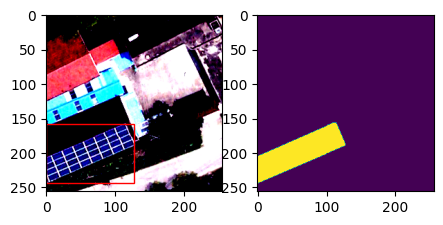

In [ ]:
boxes = masks_to_boxes(msk)
plot(img,msk,box = boxes[0])

#Define the Dataset

For this task, I read a [tutorial on the Pytorch website](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and customized its codes based on my need. Here I have defined a dataset class for my data.

In [ ]:
import os

class PanelImage(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.imgs = [img for img in listdir(data_path) if not img.endswith("mask.bmp")]

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.imgs[idx])
        mask_path = os.path.join(self.data_path,  f"{self.imgs[idx][:-4]}_mask.bmp")
        img = TF.to_tensor(Image.open(img_path).convert("RGB"))

        masks = Image.open(mask_path)
        masks = TF.to_tensor(TF.to_grayscale((masks)))
        boxes = masks_to_boxes(masks) if torch.nonzero(masks).size()[0]>0 else torch.Tensor([[0,0,0,0]])

        # there is only one class
        labels = torch.ones((1,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
            #target = self.transforms(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision.transforms as T

def get_transform():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms)

In [ ]:
import utils

data = PanelImage("processed_data")

batch_size=10
len_train = 700
len_val= len(data) - len_train
train_set, val_set = torch.utils.data.random_split(data,[len_train, len_val])

data_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle=True, pin_memory=True,
                                          collate_fn = utils.collate_fn)

validation_data_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,
                                          shuffle=True,pin_memory=True,
                                          collate_fn = utils.collate_fn)

#Model Training

## Object Detection
The tutorial on the Pytorch website has loaded and fine-tuned the MaskRCNN model which produces both segment mask and bounding box as a result. It's fascinating!

In [ ]:
import torch
import torchvision

In [ ]:
[m for m in torchvision.models.list_models() if "fpn" in m]

['fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos_resnet50_fpn',
 'keypointrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'retinanet_resnet50_fpn',
 'retinanet_resnet50_fpn_v2']

###Explore the Model

First let's try the pre-trained model as-is. I want to see the structure of its output. I have downloaded an image from the net containing several people. The `maskRCNN` model is trained on the COCO dataset and one of this dataset's labels is "person" assigned with number 1 in the labels set.

In [ ]:
model = torchvision.models.detection.retinanet_resnet50_fpn(weights="DEFAULT")
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
test_img = TF.to_tensor(Image.open("test_panel_data/test_person.jpg"))
output = model(test_img.unsqueeze(dim=0))
output[0].keys()

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 186MB/s]


dict_keys(['boxes', 'scores', 'labels'])

In [ ]:
print([(k,output[0][k].size()) for k in output[0].keys()])

[('boxes', torch.Size([243, 4])), ('scores', torch.Size([243])), ('labels', torch.Size([243]))]


In [ ]:
output[0]["scores"]

tensor([0.9107, 0.8712, 0.8604, 0.8505, 0.8486, 0.6334, 0.6041, 0.5342, 0.5279,
        0.5000, 0.4551, 0.4304, 0.4197, 0.4066, 0.3753, 0.3753, 0.3679, 0.2921,
        0.2864, 0.2863, 0.2690, 0.2672, 0.2335, 0.2321, 0.2292, 0.2277, 0.1971,
        0.1882, 0.1878, 0.1851, 0.1690, 0.1656, 0.1653, 0.1610, 0.1595, 0.1586,
        0.1558, 0.1550, 0.1496, 0.1475, 0.1466, 0.1457, 0.1455, 0.1454, 0.1451,
        0.1440, 0.1418, 0.1418, 0.1413, 0.1405, 0.1380, 0.1358, 0.1346, 0.1330,
        0.1323, 0.1309, 0.1307, 0.1277, 0.1270, 0.1249, 0.1213, 0.1213, 0.1202,
        0.1195, 0.1192, 0.1161, 0.1149, 0.1138, 0.1131, 0.1110, 0.1110, 0.1104,
        0.1095, 0.1083, 0.1081, 0.1063, 0.1061, 0.1057, 0.1052, 0.1047, 0.1046,
        0.1040, 0.1030, 0.1027, 0.1018, 0.1018, 0.1015, 0.1011, 0.1010, 0.1009,
        0.1005, 0.0993, 0.0991, 0.0981, 0.0981, 0.0974, 0.0970, 0.0969, 0.0967,
        0.0960, 0.0957, 0.0947, 0.0944, 0.0933, 0.0923, 0.0923, 0.0919, 0.0917,
        0.0916, 0.0913, 0.0911, 0.0906, 

In [ ]:
output[0]["labels"]

tensor([ 1, 32,  1,  1, 32, 75, 32,  1,  1,  1, 62,  1,  1,  1, 32,  1, 77,  1,
        72,  1, 84, 49, 64,  1,  1,  1,  1,  1, 32, 62,  1, 73,  1, 63, 84, 67,
         1,  1,  1,  1, 49, 62, 67, 48, 44, 89, 62, 67, 51, 84,  1, 84, 67,  1,
         1, 77,  1,  1, 63, 67, 84,  1, 75, 62,  1, 32, 77, 67, 63, 62, 82, 62,
        62, 65, 32, 32, 77,  1,  1, 48, 47,  1, 84, 49, 88, 64, 67,  1, 48, 31,
         1, 62, 62,  1, 47, 67, 49, 63, 67,  1, 49, 63, 67, 32, 62, 47,  1, 59,
        65, 63,  1, 28,  1, 15, 31,  1, 62, 62, 44, 75, 77, 67, 84, 62, 32, 50,
         1, 62, 75,  1,  1, 62, 67, 75, 62,  1, 84, 63, 17, 75, 32, 67,  1, 31,
        84, 90,  1, 63, 63,  1, 72,  1, 32, 67,  1, 62, 88, 76, 67, 62,  1, 77,
        62, 84, 51, 32, 84, 63, 63, 62, 31, 62, 67,  1, 49,  1,  1, 62, 82, 15,
        62, 64, 75,  1, 62, 50, 77, 72, 47, 50, 65, 82,  1, 15, 32, 67, 67, 81,
        18, 49, 65, 75, 44, 75, 67, 87, 73, 63, 49, 47, 15,  1,  1, 15, 62, 67,
        49, 50, 48, 62, 46, 67, 32,  1, 

______________
 Let's visualize the first 3 person (label 1) with the most score.

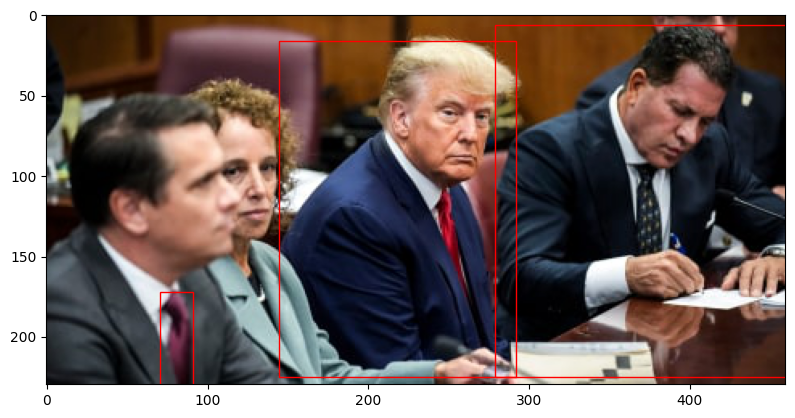

In [ ]:
image = test_img.transpose(0,2).transpose(0,1).detach().numpy()
i, im1 = plt.subplots(1)
i.set_figwidth(10)
im1.imshow(image)
box_list=output[0]["boxes"].detach().numpy()
for box in box_list[:3]:
  rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                            linewidth=1, edgecolor='r', facecolor='none')
  im1.add_patch(rect)

### Train and Finetune the Model

Time to teach this model to act on our data :)

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn

model = retinanet_resnet50_fpn(pretrained=True)

num_anchors = model.head.classification_head.num_anchors
model.head.classification_head.num_classes = 2

cls_logits = torch.nn.Conv2d(256, num_anchors * 2, kernel_size = 3, stride=1, padding=1)
model.head.classification_head.cls_logits = cls_logits

In [ ]:
from engine import train_one_epoch, evaluate
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 20

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, validation_data_loader, device=device)

    model_state = model.state_dict()
    opt_state = optimizer.state_dict()
    torch.save({'model_state_dict': model_state,
                'optimizer_state_dict': opt_state,
              }, "saved_model/retina_obj_det_w_2.pt")

Epoch: [0]  [ 0/70]  eta: 0:05:13  lr: 0.000008  loss: 1148.7351 (1148.7351)  classification: 1148.3612 (1148.3612)  bbox_regression: 0.3739 (0.3739)  time: 4.4773  data: 0.8069  max mem: 5086
Epoch: [0]  [69/70]  eta: 0:00:01  lr: 0.000500  loss: 1.4124 (197.3719)  classification: 0.9164 (196.7990)  bbox_regression: 0.4936 (0.5730)  time: 1.5541  data: 0.0579  max mem: 5400
Epoch: [0] Total time: 0:01:50 (1.5759 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:03  model_time: 0.7528 (0.7528)  evaluator_time: 0.0563 (0.0563)  time: 0.8651  data: 0.0549  max mem: 5400
Test:  [3/4]  eta: 0:00:00  model_time: 0.6876 (0.6469)  evaluator_time: 0.0533 (0.0496)  time: 0.7447  data: 0.0471  max mem: 5400
Test: Total time: 0:00:02 (0.7451 s / it)
Averaged stats: model_time: 0.6876 (0.6469)  evaluator_time: 0.0533 (0.0496)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Pr



---


**So, for now we can go to the Evaluation notebook and see the result there.**